In [3]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer




In [4]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Data manipulation and cleanup

In [5]:
df = pd.read_csv('survey data.csv')

df

,variant,group,age,gender_1F_2M_3O,education_level,education_level_otherSpecification,income_level,Country_birth,English_proficiency,religion,religion_other_spec,meditation_freq,meditation_howlong,medit_type_silent,medit_type_voice,medit_type_breath,medit_type_body,medit_type_mindfulness,bg_medit_type_other,classicalPsych_frequency,TimeSinceLastClassicalPsych,Psychiatric_No_disclosure,Psychiatric_severe_depression,Psychiatric_bipolar,Psychiatric_psychosis,Psychiatric_anxiety,Psychiatric_ASD,Psychiatric_OCD,Psychiatric_ADHD,psychiatric_other,psychiatric_selfdiagnosed,substance_use_problem,ESP1_INV,2 ESP,3 ESP,4 ESP,exp_LSD,exp_psilocybin,exp_ayahuasca,exp_DMT,exp_5meoDMT,exp_mescaline,exp_ibogaine,exp_salvia,exp_mdma,exp_ketamine,exp_cannabis,other_drug_dummy,exp_other_drug,how_many_drugs,exp_drug_dose,exp_drug_dose_specific,exp_drug_intensity,exp_drug_confidence,exp_medit_silent,exp_medit_voice,exp_medit_breath,exp_medit_body,exp_medit_mindfulness,exp_other_medit,exp_meditation_technique_specific,exp_medit_drug,exp_medit_drugSpecification,exp_when,exp_where,exp_who,exp_guide,exp_purpose_nospecific,exp_purpose_relax_enjoy,exp_purpose_spiritual,exp_purpose_therapeutic,exp_purpose_curiosity,exp_purpose_social,exp_purpose_selfimprovement,exp_purpose_distraction,exp_purpose_other,exp_other_purpose,exp_planned,exp_expect,exp_drug_meditation,exp_drug_medit_silent,exp_drug_medit_voice,exp_drug_medit_breath,exp_drug_medit_body,exp_drug_medit_mindfulness,exp_drug_medit_otherSpecify,Open_report,Open_report typo-corrected,open_report_characters,body_yes_no,Thematic_body,insight_yes_no,Thematic_insights,connection_or_alienation_yes_no,Thematic_connection,preposts_satisfied,preposts_positive,preposts_negative,preposts_meaning,preposts_peace_harmony,prepost_bodydissat,prepost_bodyappre,prepost_embodiment,MEQ30_Q1_mystical,MEQ30_Q2_mystical,MEQ30_Q3_mystical,MEQ30_Q4_mystical,MEQ30_Q5_mystical,MEQ30_Q6_mystical,MEQ30_Q7_mystical,MEQ30_Q8_mystical,MEQ30_Q9_mystical,MEQ30_Q10_mystical,MEQ30_Q11_mystical,MEQ30_Q12_mystical,MEQ30_Q13_mystical,MEQ30_Q14_mystical,MEQ30_Q15_mystical,MEQ30_Q16_positive_mood,MEQ30_Q17_positive_mood,MEQ30_Q18_positive_mood,MEQ30_Q19_positive_mood,MEQ30_Q20_positive_mood,MEQ30_Q21_positive_mood,MEQ30_Q22_transcendence,MEQ30_Q23_transcendence,MEQ30_Q24_transcendence,MEQ30_Q25_transcendence,MEQ30_Q26_transcendence,MEQ30_Q27_transcendence,MEQ30_Q28_ineffability,MEQ30_Q29_ineffability,MEQ30_Q30_ineffability,MEQ30_sum,WEMWBS_optimistic,WEMWBS_useful,WEMWBS_relaxed,WEMWBS_dealing_w_problems,WEMWBS_thinking_clearly,WEMWBS_close_to_others,WEMWBS_make_up_my_own_mind,PoMS_1,PoMS_2,PoMS_3,PoMS_4,PoMS_5_INV,PoMS_6,PoMS_7_INV,BAS1,BAS2,BAS3,BAS4,BAS5,BAS6,BAS7,BAS8,BAS9,BAS10,psy_flex1,psy_flex2,psy_flex3,psy_flex4,psy_flex5,psy_flex6,SVS_1_Power,userid
0,med1,meditation,64,2,4,NaN,2,Sweden,1,3,NaN,6,6,0,0,0,0,1,NaN,3,0,0,0,0,0,1,0,0,0,NaN,NaN,999,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,single,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,"Anapana, vipassana",1.0,NaN,6,0,0,0,0,0,0,0,0,0,1,0,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,There is a fundamental concept in Buddhism cal...,There is a fundamental concept in Buddhism cal...,408,1,I went into this in the previous question.,1,A deep understanding of what anicca means.,3,NaN,5.0,5.0,1.0,5.0,5.0,1.0,5.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,47.0,4,4,4,4,4,4,4,3,3,3,3,2,3,1,3,3,4,3,4,2,2,2,3,2,5,5,4,4,4,4,7,6097026029595349a
1,med1,meditation,31,2,7,NaN,4,India,1,5,NaN,4,5,0,0,0,0,1,Vipassana,0,0,0,0,0,0,0,0,0,0,NaN,Mild anxiety,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,single,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,Vipassana,1.0,NaN,7,5,3,1,0,0,1,0,0,0,0,0,0,NaN,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I developed all positive feelings. All thought...,I developed all positive feelings. All thought...,158,3,NaN,1,I realized I love my family. I realized that I...,2,NaN,3.0,5.0,

In [6]:
# Saving a csv file for parallel analysis with GPT-4
df[['group', 'Open_report typo-corrected']].to_csv('open_report_for_gpt4.csv', index=False)


In [7]:
# Only keeping the columns that we need

columns_to_keep = ['group', 'age', 'gender_1F_2M_3O', 'income_level', 'education_level', 'Open_report typo-corrected']

df = df[columns_to_keep] 

df

,group,age,gender_1F_2M_3O,income_level,education_level,Open_report typo-corrected
0,meditation,64,2,2,4,There is a fundamental concept in Buddhism cal...
1,meditation,31,2,4,7,I developed all positive feelings. All thought...
2,meditation,45,1,2,7,I had recently lost my father unexpectedly. A ...
3,meditation,33,2,3,6,There was an objective experience of the self ...
4,meditation,56,2,4,6,Deep abiding peace with understanding of the i...
...,...,...,...,...,...,...
208,psychedelics,31,2,2,7,"It's impossible to write down what happened, a..."
209,psychedelics,31,2,3,6,You are okay I took approximately half of what...
210,psychedelics,56,1,5,6,There was an intention setting and intake appt...
211,psychedelics,40,1,4,7,My memory is quite vague as it was almost 5 ye...


In [8]:
# # Replacing the abbreviation gf with the actual word girlfriend (this came up while running some preliminary analyses)
# df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf ', 'girlfriend ')
# df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf)', 'girlfriend)')


In [9]:
# Dropping rows where open report is empty
df = df.dropna(subset=['Open_report typo-corrected'])

In [10]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 0 to 212
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   group                       203 non-null    object
 1   age                         203 non-null    int64 
 2   gender_1F_2M_3O             203 non-null    int64 
 3   income_level                203 non-null    int64 
 4   education_level             203 non-null    int64 
 5   Open_report typo-corrected  203 non-null    object
dtypes: int64(4), object(2)
memory usage: 11.1+ KB


In [11]:
df['group'] = df['group'].astype('category')
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].astype('string')

/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/3570789679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['group'].astype('category')
/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/3570789679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Open_report typo-corrected'] = df['Open_report typo-corrected'].astype('string')


In [12]:
# Creating separate dataframes for psychedelics and meditation groups

psyke = df[df['group']=='psychedelics']

medi = df[df['group']=='meditation']

psyke_count = len(psyke)
medi_count = len(medi)

print(f"Number of answers in 'psychedelics' group: {psyke_count}")
print(f"Number of answers in 'meditation' group: {medi_count}")

Number of answers in 'psychedelics' group: 138
Number of answers in 'meditation' group: 65


In [13]:
# Demographic data

# Replace gender values according to the instructions
df['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)

mean_age = round(df['age'].mean(), 2)
std_age = round(df['age'].std(), 2)
print(f"Mean age: {mean_age} (std: {std_age})")

gender_distribution = df['gender_1F_2M_3O'].value_counts()
gender_distribution_percentage = round(df['gender_1F_2M_3O'].value_counts(normalize=True) * 100, 2)
print("Gender distribution:\n", gender_distribution)
print("\nGender distribution (in percentage):\n", gender_distribution_percentage)

mean_income = round(df['income_level'].mean(), 2)
std_income = round(df['income_level'].std(), 2)
print(f"Mean income level: {mean_income} (std: {std_income})")


mean_education_level = round(df['education_level'].mean(), 2)
std_education_level = round(df['education_level'].std(), 2)
print(f"Mean education level: {mean_education_level} (std: {std_education_level})")



Mean age: 43.13 (std: 14.48)
Gender distribution:
 gender_1F_2M_3O
male      120
female     79
other       4
Name: count, dtype: int64

Gender distribution (in percentage):
 gender_1F_2M_3O
male      59.11
female    38.92
other      1.97
Name: proportion, dtype: float64
Mean income level: 3.16 (std: 1.14)
Mean education level: 59.92 (std: 225.34)


/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/824256517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)


Education level distribution:
 education_level
7      70
6      64
8      25
3      17
999    11
4       9
2       6
1       1
Name: count, dtype: int64

Education level distribution (in percentage):
 education_level
7      34.48
6      31.53
8      12.32
3       8.37
999     5.42
4       4.43
2       2.96
1       0.49
Name: proportion, dtype: float64


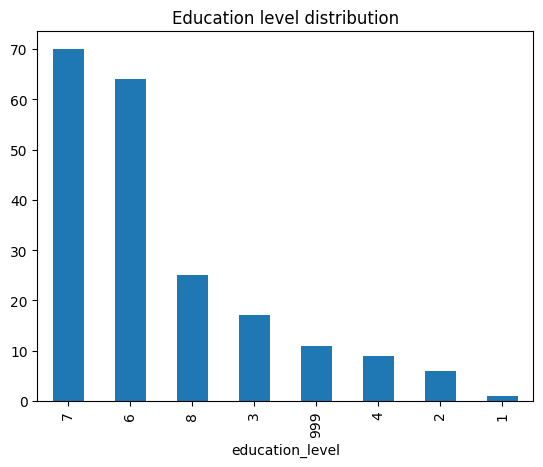

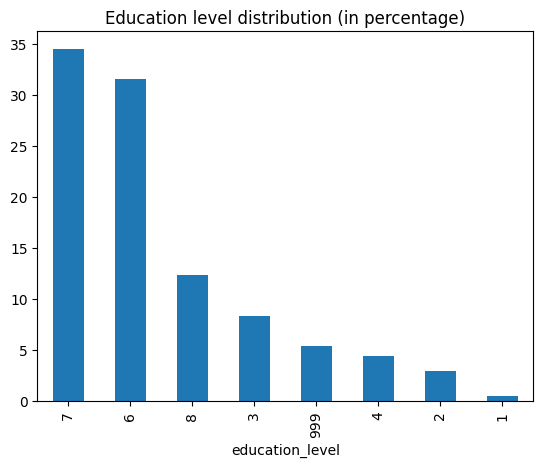

In [14]:
education_level_distribution = df['education_level'].value_counts()
education_level_distribution_percentage = round(df['education_level'].value_counts(normalize=True) * 100, 2)
print("Education level distribution:\n", education_level_distribution)
print("\nEducation level distribution (in percentage):\n", education_level_distribution_percentage)

education_level_distribution.plot(kind='bar', title='Education level distribution')
plt.show()

education_level_distribution_percentage.plot(kind='bar', title='Education level distribution (in percentage)')
plt.show()


### Checking word distributions

In [15]:
total_words = df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).sum()
print(f"Total number of words in 'Open_report typo-corrected': {total_words}")


Total number of words in 'Open_report typo-corrected': 72996


<Axes: >

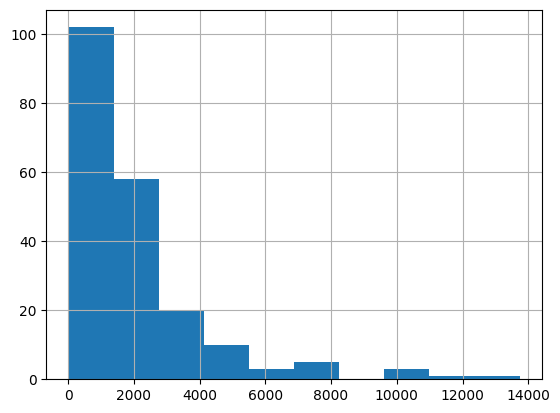

In [16]:
# Histogram of the answer lengths (in tokens)

df['Open_report typo-corrected'].str.len().hist()

<Axes: >

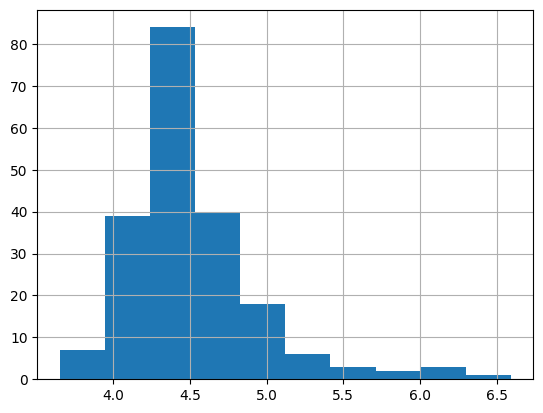

In [17]:
# Histogram of word lengths

df['Open_report typo-corrected'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

Text(0, 0.5, 'Count of Answers')

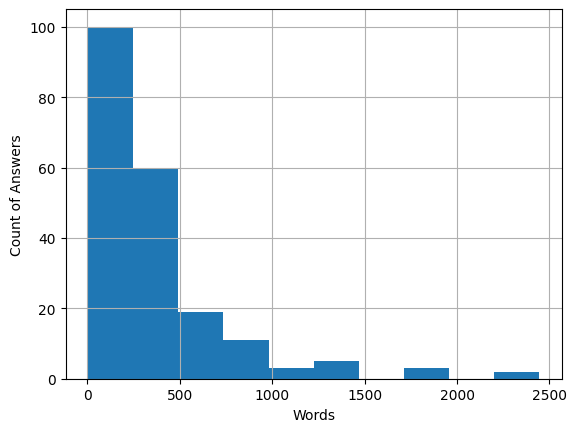

In [18]:
# Histogram of answer lengths (in words)

ax = df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).hist()
ax.set_xlabel("Words")
ax.set_ylabel("Count of Answers")


In [19]:
# Average length of the documents for all groups
avg_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for all groups: {avg_answer_length} (std: {std_answer_length})")

# Average length of the documents for 'psychedelics' group
avg_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'psychedelics' group: {avg_answer_length_psyke} (std: {std_answer_length_psyke})")

# Average length of the documents for 'meditation' group
avg_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'meditation' group: {avg_answer_length_medi} (std: {std_answer_length_medi})")


Average length of answers in words for all groups: 359.59 (std: 401.19)
Average length of answers in words for 'psychedelics' group: 400.41 (std: 443.66)
Average length of answers in words for 'meditation' group: 272.92 (std: 274.63)


<BarContainer object of 10 artists>

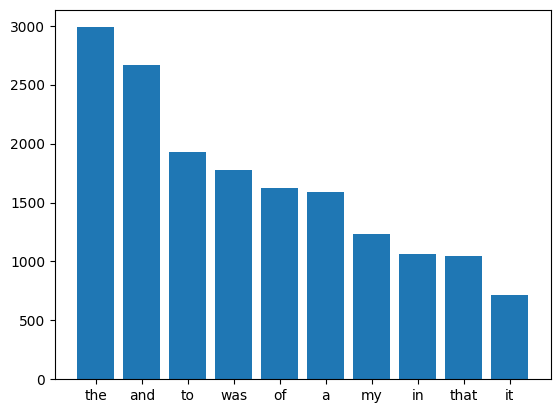

In [20]:
# Visualising the most common stopwords in the dataset
stop_words = set(stopwords.words('english'))

corpus = []
words = df['Open_report typo-corrected'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

# Word frequency comparisons between the groups

In [21]:
from collections import Counter
import spacy


In [22]:
nlp = spacy.load("en_core_web_sm")

psyke_all_text = psyke['Open_report typo-corrected'].str.cat(sep=' ')

psyke_doc = nlp(psyke_all_text, disable=['ner'])

In [23]:
medi_all_text = medi['Open_report typo-corrected'].str.cat(sep=' ')

medi_doc = nlp(medi_all_text, disable=['ner'])


In [24]:
psyke_words = [token.lemma_ for token in psyke_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
psyke_word_freq = Counter(psyke_words) 
psyke_word_freq.most_common(20)

[('feel', 569),
 ('experience', 388),
 ('like', 342),
 ('time', 241),
 ('start', 222),
 ('go', 175),
 ('life', 159),
 ('friend', 158),
 ('know', 144),
 ('think', 140),
 ('come', 134),
 ('trip', 134),
 ('take', 133),
 ('see', 129),
 ('thing', 114),
 ('get', 112),
 ('remember', 111),
 ('feeling', 107),
 ('body', 101),
 ('look', 101)]

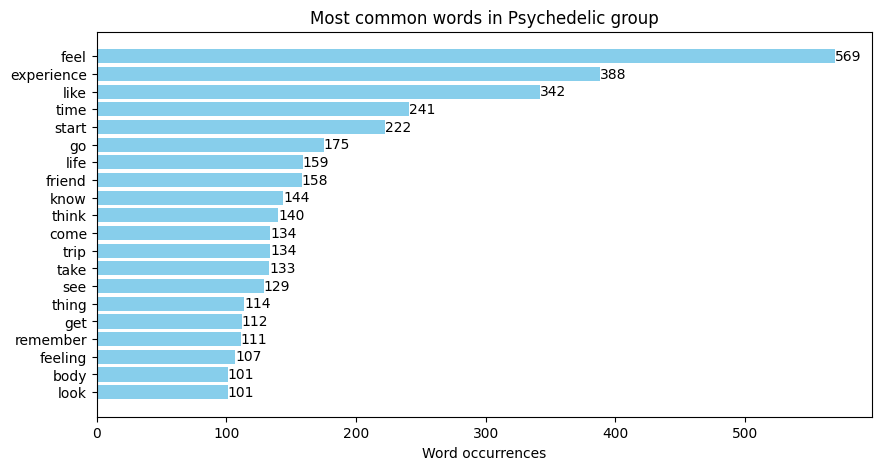

In [25]:
psyke_common_words = psyke_word_freq.most_common(20)
words, counts = zip(*psyke_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Psychedelic group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()


In [26]:
medi_words = [token.lemma_ for token in medi_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
medi_word_freq = Counter(medi_words) 
medi_word_freq.most_common(20)

[('experience', 190),
 ('feel', 154),
 ('like', 91),
 ('meditation', 89),
 ('time', 80),
 ('body', 77),
 ('day', 69),
 ('practice', 57),
 ('retreat', 56),
 ('mind', 52),
 ('life', 50),
 ('know', 42),
 ('come', 38),
 ('year', 37),
 ('happen', 36),
 ('love', 36),
 ('start', 34),
 ('sense', 34),
 ('go', 34),
 ('sit', 32)]

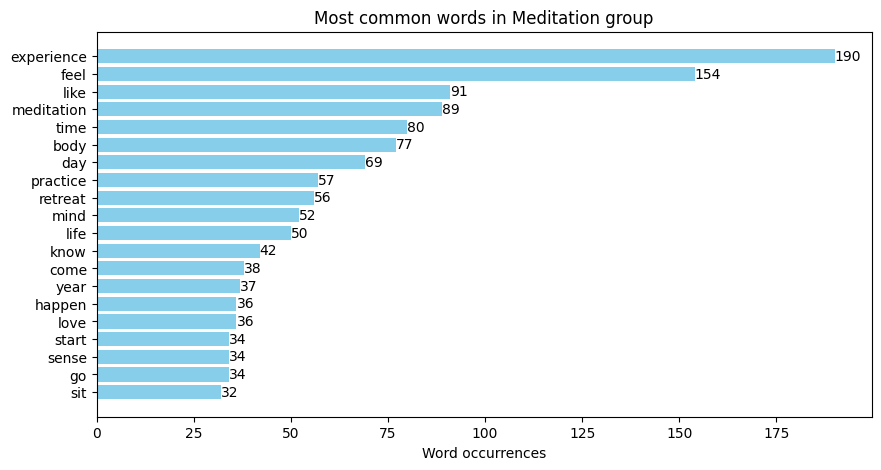

In [27]:
medi_common_words = medi_word_freq.most_common(20)
words, counts = zip(*medi_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Meditation group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()



### Most common ngrams

In [28]:
# Defining the functions for finding most common ngrams with and without stopwords

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

#Including stopwords
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


#Excluding stopwords
def get_top_ngram_without_stop(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    words_freq = [(word, count) for word, count in words_freq if all(w not in stop_words for w in word.split())]
    return words_freq[:10]



Text(0.5, 1.0, 'Psychedelic group most common bigrams')

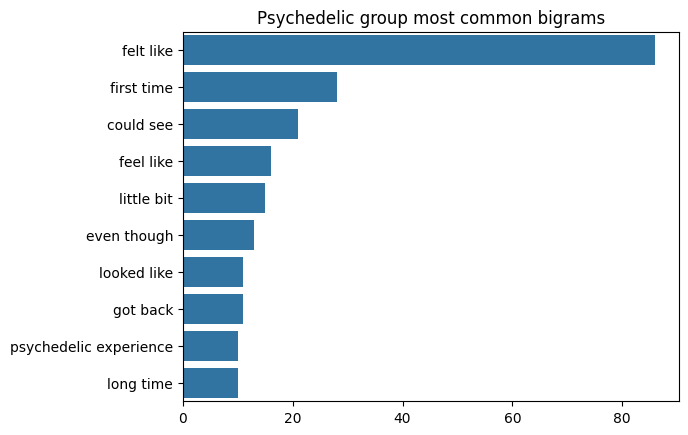

In [29]:
# Top bigrams without stopwords psychedelic group 
top_n_bigrams_psyke=get_top_ngram_without_stop(psyke['Open_report typo-corrected'],2)[:10] 

x,y=map(list,zip(*top_n_bigrams_psyke)) 

sns.barplot(x=y,y=x).set_title("Psychedelic group most common bigrams")


Text(0.5, 1.0, 'Meditation group most common bigrams')

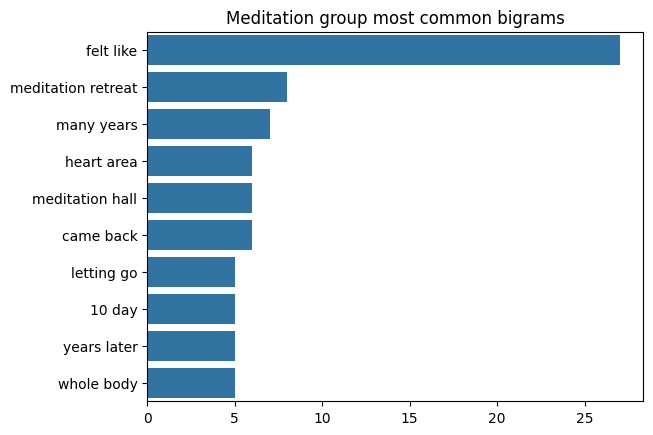

In [30]:
# Top bigrams without stopwords meditation group
top_n_bigrams_medi=get_top_ngram_without_stop(medi['Open_report typo-corrected'],2)[:10] 

x,y=map(list,zip(*top_n_bigrams_medi)) 

sns.barplot(x=y,y=x).set_title("Meditation group most common bigrams")

# Using the spacy approach 

#### https://robertorocha.info/using-nlp-to-analyze-open-ended-responses-in-surveys/

In [31]:


all_text = df['Open_report typo-corrected'].str.cat(sep=' ')

doc = nlp(all_text, disable=['ner'])

In [32]:
# Most common verbs

verbs = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.pos_ == "VERB"]
verb_freq = Counter(verbs)
verb_freq.most_common(20)


[('feel', 719),
 ('start', 253),
 ('go', 209),
 ('know', 185),
 ('think', 171),
 ('come', 165),
 ('see', 153),
 ('take', 147),
 ('remember', 131),
 ('look', 121),
 ('get', 121),
 ('happen', 121),
 ('experience', 105),
 ('want', 102),
 ('try', 88),
 ('say', 84),
 ('sit', 76),
 ('find', 74),
 ('walk', 72),
 ('tell', 68)]

In [33]:
from spacy.matcher import Matcher 

matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 

matches = matcher(doc, as_spans=True) 
phrases = [] 
for span in matches:
    phrases.append(span.text.lower())
    phrase_freq = Counter(phrases)

phrase_freq.most_common(30)

[('first time', 32),
 ('same time', 16),
 ('little bit', 16),
 ('other people', 15),
 ('long time', 13),
 ('many years', 12),
 ('psychedelic experience', 10),
 ('whole body', 9),
 ('few hours', 9),
 ('next day', 8),
 ('few times', 8),
 ('present moment', 8),
 ('psychedelic experiences', 8),
 ('many times', 7),
 ('everyday life', 6),
 ('whole life', 6),
 ('whole universe', 6),
 ('several hours', 6),
 ('few days', 6),
 ('hard time', 6),
 ('whole experience', 5),
 ('first thing', 5),
 ('nervous system', 5),
 ('same thing', 5),
 ('ego death', 5),
 ('magic mushrooms', 5),
 ('total bliss', 5),
 ('mental health', 4),
 ('important part', 4),
 ('unconditional love', 4)]

In [34]:
# Showing adjectives that follow sentences "I/we feel/am/are"

feel_adj = []
matcher = Matcher(nlp.vocab)
pattern = [{'LOWER' : {'IN' : ['i', 'we']}}, {'OP': '?'}, 
  {'LOWER': {'IN' : ['feel', 'am', "'m", 'are', "'re"]}}, 
  {'OP': '?'}, {'OP': '?'}, {'POS':'ADJ'}]
matcher.add("FeelAdj", [pattern]) 
matches = matcher(doc, as_spans=True) 

for span in matches:
    feel_adj.extend([token.lemma_ for token in span if token.pos_ == 'ADJ'])

Counter(feel_adj).most_common(20)

[('sure', 8),
 ('able', 6),
 ('grateful', 6),
 ('whole', 3),
 ('same', 3),
 ('aware', 3),
 ('sub', 3),
 ('present', 2),
 ('enough', 2),
 ('different', 2),
 ('alone', 2),
 ('vivid', 2),
 ('connected', 2),
 ('lonely', 2),
 ('reborn', 2),
 ('middle', 2),
 ('licensed', 2),
 ('-', 2),
 ('tired', 1),
 ('healthy', 1)]

In [35]:
want_adj = []
matcher = Matcher(nlp.vocab) 

pattern = [{'LOWER' : {'IN' : ['i', 'we']}}, {'IS_ALPHA':True, 'OP':'?'},
   {'LOWER': {'IN' : ['need', 'want']}}, {'IS_ALPHA':True, 'OP':'?'},
   {'IS_ALPHA':True, 'OP':'?'}, {'POS':'NOUN'}]
   
matcher.add("WantPhrase", [pattern]) 
matches = matcher(doc, as_spans=True)

In [36]:
for match in matches:
    print(match.text)

I need more love
I really want salvation
I want my daughter
i want people
I want from life
we need advice


In [37]:
# Checking which words occur near the word "experience"

from spacy.matcher import PhraseMatcher

mental_health_colloc = []
matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
# The attr above ensures all instances are converted to lower-case so the search is case-insensitive

pattern = [nlp.make_doc('experience')]
matcher.add('experience', pattern) 
matches = matcher(doc)

for match_id, start, end in matches:
    span = doc[start-10 : end+10]   
    mental_health_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 

Counter(mental_health_colloc).most_common(20)

[('experience', 478),
 ('feel', 62),
 (' ', 33),
 ('time', 32),
 ('like', 31),
 ('life', 29),
 ('psychedelic', 25),
 ('think', 21),
 ('happen', 21),
 ('way', 21),
 ('day', 20),
 ('change', 19),
 ('take', 19),
 ('feeling', 18),
 ('start', 17),
 ('go', 17),
 ('hour', 17),
 ('body', 16),
 ('trip', 15),
 ('year', 14)]

### Pre-processing the open answers by removing stopwords and lemmatising the words
Previously the stopwords were removed and words lemmatised while calculating the frequencies, but I didn't touch the actual dataframes. Now, we need preprocessed dataframes for LDA and Sentiment analysis.  

In [38]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

# Creating the pre-processing functions
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Defining a mapping of words to their base forms
manual_mapping = {
    'felt': 'feel',
    'talked': 'talk',
    'thought': 'think',
}

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [manual_mapping.get(token, token) for token in tokens] 
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/konsta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [39]:
# Pre-processing psyke and medi datasets

psyke_pre_processed_answers = psyke['Open_report typo-corrected'].apply(preprocess_text)
medi_pre_processed_answers = medi['Open_report typo-corrected'].apply(preprocess_text)



## TF-IDF analysis

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the tf-idf vectorizers
tfidf_vectorizer_psyke = TfidfVectorizer()
tfidf_vectorizer_medi = TfidfVectorizer()

# Apply the vectorizers to the preprocessed answers
X_psyke = tfidf_vectorizer_psyke.fit_transform(psyke_pre_processed_answers)
X_medi = tfidf_vectorizer_medi.fit_transform(medi_pre_processed_answers)



Psychedelic group top words:


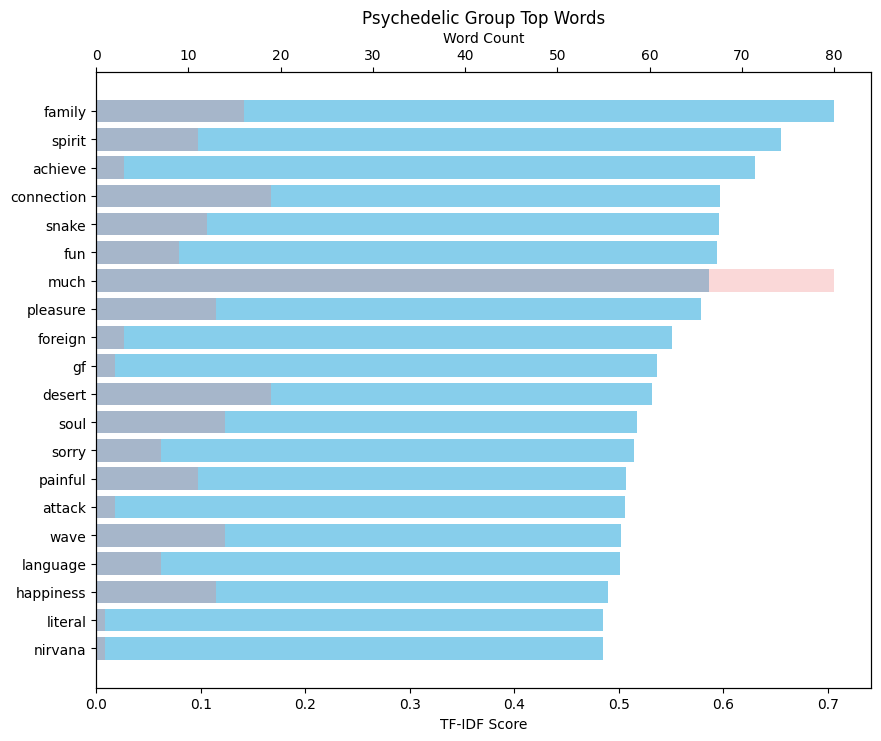

Meditation group top words:


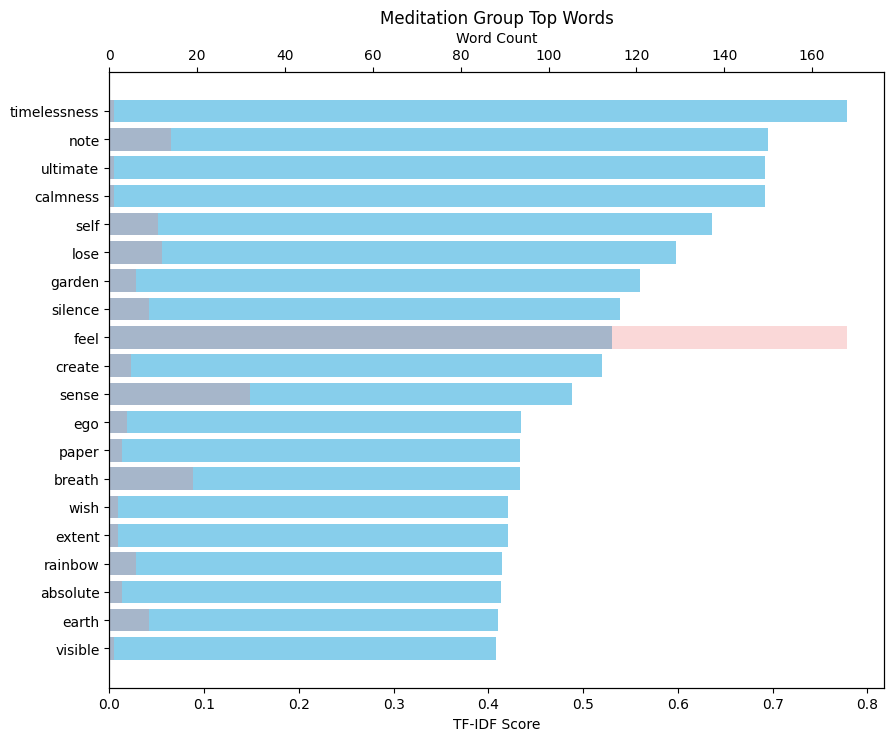

In [41]:
# Create the count vectorizers
count_vectorizer_psyke = CountVectorizer()
count_vectorizer_medi = CountVectorizer()

# Apply the vectorizers to the preprocessed answers
X_psyke_count = count_vectorizer_psyke.fit_transform(psyke_pre_processed_answers)
X_medi_count = count_vectorizer_medi.fit_transform(medi_pre_processed_answers)

def plot_top_tfidf_words(vectorizer, tfidf_result, count_vectorizer, count_result, top_n, title):
    feature_names = vectorizer.get_feature_names_out()
    sorted_nzs = np.argsort(tfidf_result.data)[:-(top_n+1):-1]
    top_words = feature_names[tfidf_result.indices[sorted_nzs]]
    top_scores = tfidf_result.data[sorted_nzs]
    
    # Get word counts
    word_counts = count_result.sum(axis=0).A1
    count_dict = dict(zip(count_vectorizer.get_feature_names_out(), word_counts))
    top_counts = [count_dict[word] for word in top_words]
    
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plot TF-IDF scores
    ax1.barh(top_words, top_scores, color='skyblue')
    ax1.set_xlabel('TF-IDF Score')
    ax1.set_title(title)

    # Plot word counts on the same graph but with a different x-axis
    ax2 = ax1.twiny()
    ax2.barh(top_words, top_counts, color='lightcoral', alpha=0.3)
    ax2.set_xlabel('Word Count')

    # Invert y-axis
    plt.gca().invert_yaxis()
    plt.show()

# Psychedelic group
print("Psychedelic group top words:")
plot_top_tfidf_words(tfidf_vectorizer_psyke, X_psyke, count_vectorizer_psyke, X_psyke_count, 20, 'Psychedelic Group Top Words')

# Meditation group
print("Meditation group top words:")
plot_top_tfidf_words(tfidf_vectorizer_medi, X_medi, count_vectorizer_medi, X_medi_count, 20, 'Meditation Group Top Words')

# Topic analysis with LDA

### Testing the LDA model with different number of topics (k) and checking words inside the topic models 

In [42]:
# Psychedelic data

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Define the number of topics for each model
num_topics_list = [3, 5, 10, 15, 20, 25, 30]

# Vectorizing the preprocessed text and creating document-term matrices
vectorizer_psyke = CountVectorizer()
psyke_dtm = vectorizer_psyke.fit_transform(psyke_pre_processed_answers)

# Function to print top 10 words for each topic
def print_top_words(model, vectorizer, n_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx + 1}: "
        message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

# Train LDA models and print top words
for num_topics in num_topics_list:
    print(f"\nModel with {num_topics} topics:")
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(psyke_dtm)
    print_top_words(lda_model, vectorizer_psyke)


Model with 3 topics:
Topic #1: feel, experience, like, go, time, one, could, take, would, start
Topic #2: experience, feel, like, time, trip, saw, go, get, could, life
Topic #3: feel, like, start, experience, time, go, friend, get, one, life

Model with 5 topics:
Topic #1: experience, feel, go, like, one, could, time, come, life, see
Topic #2: experience, god, like, could, see, feel, friend, think, saw, trip
Topic #3: feel, experience, start, make, like, one, body, friend, go, everything
Topic #4: experience, feel, time, hour, also, life, one, make, consciousness, note
Topic #5: feel, like, time, experience, start, go, get, take, could, friend

Model with 10 topics:
Topic #1: feel, go, like, come, experience, one, get, could, take, body
Topic #2: experience, god, impossible, like, color, trip, anything, another, see, boom
Topic #3: feel, like, experience, one, body, life, child, strong, try, everything
Topic #4: experience, reality, see, one, feel, way, lot, consciousness, life, back


In [43]:
# Meditation data

# Vectorize the preprocessed text
vectorizer_medi = CountVectorizer()
medi_dtm = vectorizer_medi.fit_transform(medi_pre_processed_answers)

# Train LDA models and print top words
for num_topics in num_topics_list:
    print(f"\nModel with {num_topics} topics:")
    lda_model_medi = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model_medi.fit(medi_dtm)
    print_top_words(lda_model_medi, vectorizer_medi)


Model with 3 topics:
Topic #1: experience, meditation, note, think, day, feel, retreat, body, life, like
Topic #2: feel, experience, body, meditation, like, day, retreat, practice, time, go
Topic #3: experience, time, like, feel, mind, life, meditation, state, one, could

Model with 5 topics:
Topic #1: experience, time, day, intense, see, realize, breath, hearing, really, use
Topic #2: feel, experience, like, day, body, meditate, one, time, word, go
Topic #3: experience, time, mind, could, like, feel, life, state, nyams, yet
Topic #4: feel, experience, meditation, body, like, practice, retreat, life, day, could
Topic #5: time, experience, retreat, go, heart, feel, practice, happen, many, back

Model with 10 topics:
Topic #1: time, experience, intense, realize, day, use, breath, hearing, really, act
Topic #2: feel, experience, one, garden, use, state, go, time, calm, day
Topic #3: experience, time, different, level, mind, state, colour, something, rainbow, light
Topic #4: experience, f

### Final topic models for psychedelic and meditation groups
Defined by using the model from Wheeler et al. (2021): https://link.springer.com/chapter/10.1007/978-3-030-74772-5_24. However, with meditation group the article's recommendations are not followed (it suggests using only 2 topics for meditation), because I wanted to have same amount of topics for the both model, which also would make sense for human readers. Therefore, the k parameter is set to 5 with both datasets.

In [44]:
lda_model_psyke = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_psyke.fit(psyke_dtm)
print("Psychedelics:")
print_top_words(lda_model_psyke, vectorizer_psyke)

lda_model_medi = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model_medi.fit(medi_dtm)
print("Meditation:")
print_top_words(lda_model_medi, vectorizer_medi)


Psychedelics:
Topic #1: experience, feel, go, like, one, could, time, come, life, see
Topic #2: experience, god, like, could, see, feel, friend, think, saw, trip
Topic #3: feel, experience, start, make, like, one, body, friend, go, everything
Topic #4: experience, feel, time, hour, also, life, one, make, consciousness, note
Topic #5: feel, like, time, experience, start, go, get, take, could, friend
Meditation:
Topic #1: experience, time, day, intense, see, realize, breath, hearing, really, use
Topic #2: feel, experience, like, day, body, meditate, one, time, word, go
Topic #3: experience, time, mind, could, like, feel, life, state, nyams, yet
Topic #4: feel, experience, meditation, body, like, practice, retreat, life, day, could
Topic #5: time, experience, retreat, go, heart, feel, practice, happen, many, back


### GPT-4 interpretation of the topics:

I didn't reveal to the model that it's about psychedelic and meditation experiences, so it should be relatively unbiased in that regard. 

Psychedelics:
1. General Experience: This topic seems to cover the general experience of an event or situation, including feelings and perceptions.
2. Spiritual Experience: This topic might be related to spiritual or transcendent experiences, as indicated by words like 'god' and 'saw'.
3. Physical and Emotional Experience: This topic could be about the physical and emotional sensations experienced during an event or situation.
4. Time Perception: This topic might be about the altered perception of time and consciousness during an experience.
5. Social Experience: This topic could be about the social aspect of an experience, including experiences with friends.

Meditation:
1. Intense Experience: This topic might be about intense or profound experiences, possibly involving sensory perceptions.
2. Body Awareness: This topic could be about the increased body awareness and feelings experienced during an activity, possibly meditation.
3. Mindfulness: This topic might be about the mindfulness aspect of an activity, including awareness of one's mind and life.
4. Meditation Practice: This topic could be about the practice of meditation itself, including retreats and daily practice.
5. Transformation: This topic might be about the transformative aspects of an activity, including changes in feelings and practices over time.

### Analysing the topics

In [45]:
# Get the topic distribution for each document
psyke_topic_distribution = lda_model_psyke.transform(psyke_dtm)

# Convert the topic distribution to a DataFrame
psyke_topic_distribution_df = pd.DataFrame(psyke_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_psyke.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
psyke_with_topics = pd.concat([psyke_pre_processed_answers.reset_index(drop=True), psyke_topic_distribution_df], axis=1)

psyke_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,friend apartment take lsd let say fairly avera...,0.001758,0.001756,0.001751,0.001756,0.992979
1,mean last experience take ketamine experienced...,0.341885,0.003492,0.330796,0.003534,0.320294
2,first time eat mushroom get away depression ay...,0.015758,0.015500,0.015654,0.015671,0.937417
3,close friend take shrooms nice walk around tow...,0.006548,0.006617,0.006515,0.006624,0.973697
4,many testimonial experienced connection nature...,0.003454,0.003437,0.003525,0.003442,0.986143


In [46]:
# Get the topic distribution for each document
medi_topic_distribution = lda_model_medi.transform(medi_dtm)

# Convert the topic distribution to a DataFrame
medi_topic_distribution_df = pd.DataFrame(medi_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_medi.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
medi_with_topics = pd.concat([medi_pre_processed_answers.reset_index(drop=True), medi_topic_distribution_df], axis=1)

medi_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,fundamental concept buddhism call anicca regar...,0.005298,0.005323,0.005361,0.978676,0.005342
1,developed positive feeling thought mind look l...,0.012573,0.012632,0.012764,0.949248,0.012783
2,recently lose father unexpectedly month funera...,0.004360,0.004392,0.004465,0.982384,0.004398
3,objective experience self voice separate entit...,0.003743,0.003772,0.003767,0.984919,0.003799
4,deep abide peace understand impermanence exper...,0.011823,0.011946,0.011933,0.952357,0.011941


In [47]:
# Calculate the average contribution of each topic for both Psyke and Medi
psyke_average_topic_contributions = psyke_topic_distribution_df.mean().round(3)
medi_average_topic_contributions = medi_topic_distribution_df.mean().round(3)

# Print the average contribution of each topic for both Psyke and Medi
print("Psyke average topic contributions:")
print(psyke_average_topic_contributions)
print("\nMedi average topic contributions:")
print(medi_average_topic_contributions)

Psyke average topic contributions:
Topic_1    0.128
Topic_2    0.075
Topic_3    0.138
Topic_4    0.095
Topic_5    0.564
dtype: float64

Medi average topic contributions:
Topic_1    0.061
Topic_2    0.137
Topic_3    0.163
Topic_4    0.524
Topic_5    0.115
dtype: float64


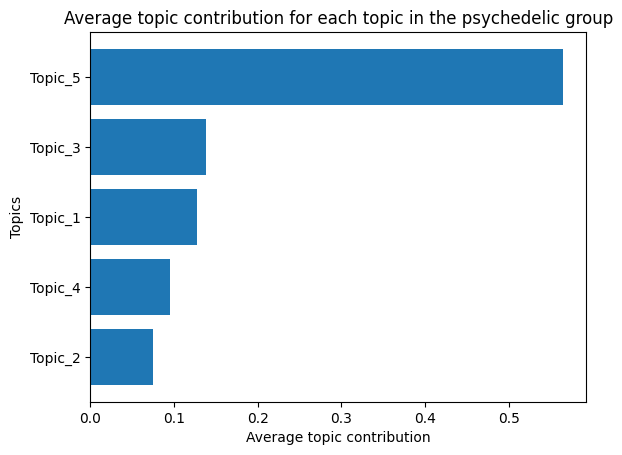

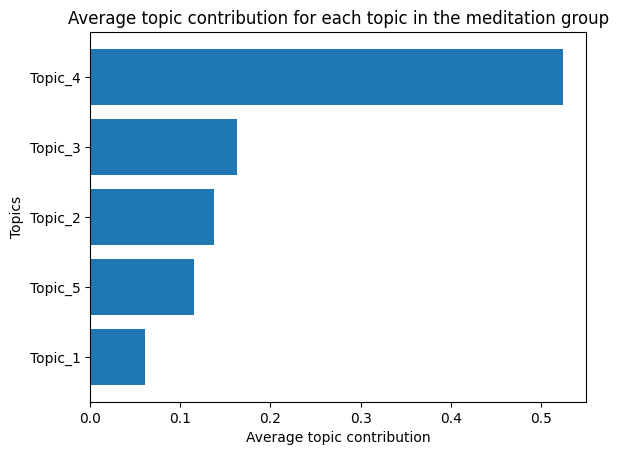

In [48]:
# Visualising the topic contributions for psyke
sorted_topics_psyke = psyke_average_topic_contributions.sort_values()
fig, ax = plt.subplots()
ax.barh(sorted_topics_psyke.index, sorted_topics_psyke.values)
ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the psychedelic group')
plt.show()

# Visualising the topic contributions for medi
sorted_topics_medi = medi_average_topic_contributions.sort_values()
fig, ax = plt.subplots()
ax.barh(sorted_topics_medi.index, sorted_topics_medi.values)
ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the meditation group')
plt.show()


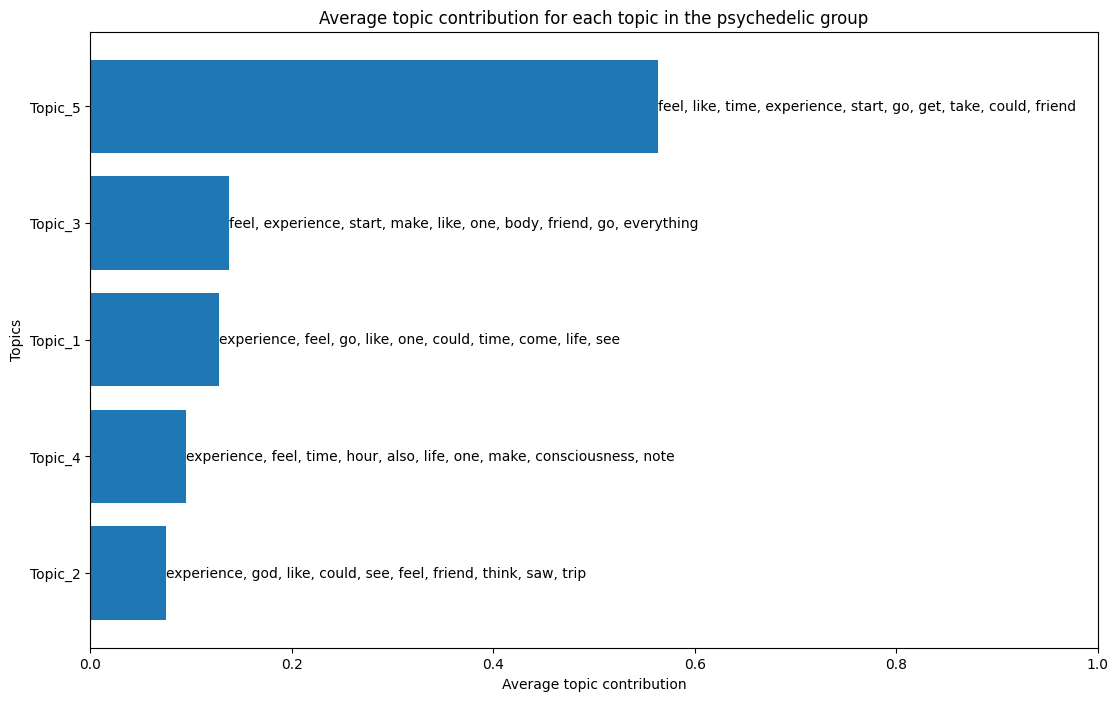

In [49]:
# Assuming you have a dictionary of top words for each topic
psyke_top_words_dict = {
    "Topic_1": "experience, feel, go, like, one, could, time, come, life, see",
    "Topic_2": "experience, god, like, could, see, feel, friend, think, saw, trip",
    "Topic_3": "feel, experience, start, make, like, one, body, friend, go, everything",
    "Topic_4": "experience, feel, time, hour, also, life, one, make, consciousness, note",
    "Topic_5": "feel, like, time, experience, start, go, get, take, could, friend"
}


# Visualising the topic contributions for psyke
sorted_topics_psyke = psyke_average_topic_contributions.sort_values()
fig, ax = plt.subplots(figsize=(13, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_psyke.index, sorted_topics_psyke.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_psyke.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, psyke_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the psychedelic group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])

plt.show()

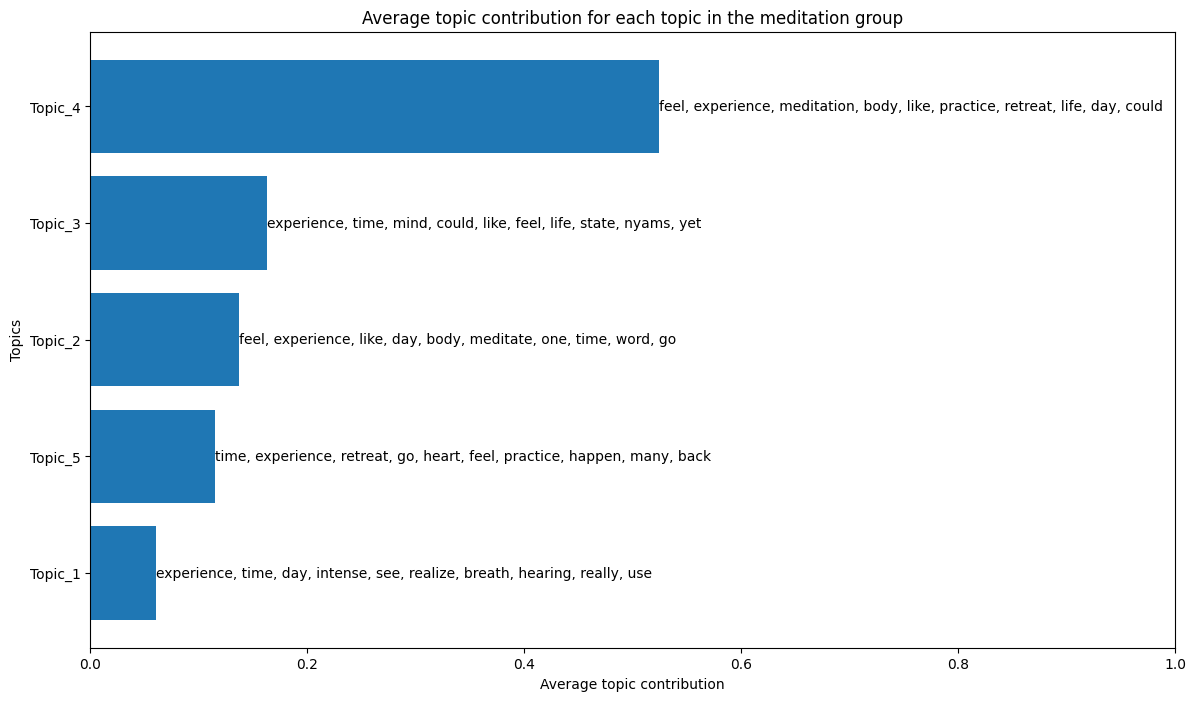

In [50]:
# Assuming you have a dictionary of top words for each topic
medi_top_words_dict = {
    "Topic_1": "experience, time, day, intense, see, realize, breath, hearing, really, use",
    "Topic_2": "feel, experience, like, day, body, meditate, one, time, word, go",
    "Topic_3": "experience, time, mind, could, like, feel, life, state, nyams, yet",
    "Topic_4": "feel, experience, meditation, body, like, practice, retreat, life, day, could",
    "Topic_5": "time, experience, retreat, go, heart, feel, practice, happen, many, back"
}



# Visualising the topic contributions for medi
sorted_topics_medi = medi_average_topic_contributions.sort_values()
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_medi.index, sorted_topics_medi.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_medi.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, medi_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the meditation group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])

plt.show()

# Sentiment analysis

In [51]:
psyke.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 66 to 212
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   group                       138 non-null    category
 1   age                         138 non-null    int64   
 2   gender_1F_2M_3O             138 non-null    int64   
 3   income_level                138 non-null    int64   
 4   education_level             138 non-null    int64   
 5   Open_report typo-corrected  138 non-null    string  
dtypes: category(1), int64(4), string(1)
memory usage: 6.7 KB


In [52]:
medi.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 0 to 65
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   group                       65 non-null     category
 1   age                         65 non-null     int64   
 2   gender_1F_2M_3O             65 non-null     int64   
 3   income_level                65 non-null     int64   
 4   education_level             65 non-null     int64   
 5   Open_report typo-corrected  65 non-null     string  
dtypes: category(1), int64(4), string(1)
memory usage: 3.2 KB


In [59]:
from nltk.sentiment import SentimentIntensityAnalyzer




In [60]:
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()


In [61]:

psyke['sentiment_scores'] = psyke['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))

psyke['compound_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['compound'])
psyke['positive_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['pos'])
psyke['neutral_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['neu'])
psyke['negative_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['neg'])


medi['sentiment_scores'] = medi['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))

medi['compound_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['compound'])
medi['positive_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['pos'])
medi['neutral_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['neu'])
medi['negative_sentiment'] = medi['sentiment_scores'].apply(lambda x: x['neg'])


print(psyke[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']])
print(medi[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']])



     compound_sentiment  positive_sentiment  neutral_sentiment  \
66               0.9826               0.140              0.841   
67               0.5668               0.098              0.843   
68               0.4019               0.255              0.598   
69               0.5106               0.084              0.879   
70               0.9332               0.217              0.698   
71              -0.9927               0.095              0.743   
72               0.9019               0.143              0.801   
73               0.4013               0.062              0.898   
74               0.9973               0.139              0.781   
75               0.6310               0.255              0.745   
76               0.8590               0.237              0.629   
77              -0.7430               0.126              0.630   
78               0.9508               0.181              0.716   
79               0.9721               0.150              0.828   
80        

/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/2094079721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['sentiment_scores'] = psyke['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))
/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/2094079721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['compound_sentiment'] = psyke['sentiment_scores'].apply(lambda x: x['compound'])
/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/

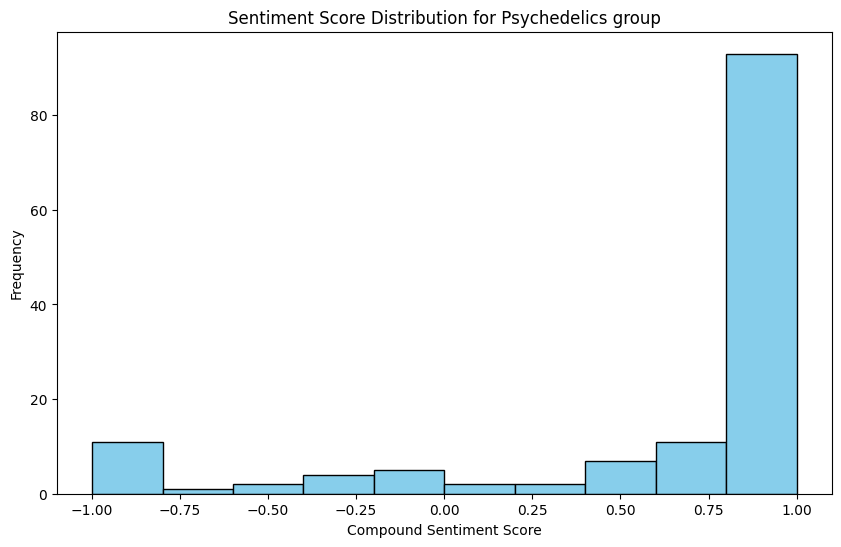

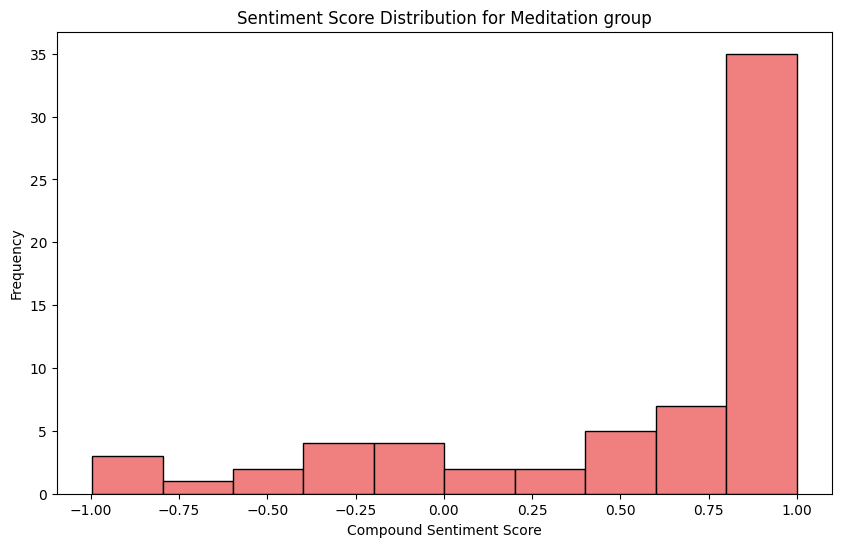

In [62]:
# Creating a sentiment histogram for Psychedelics group
plt.figure(figsize=(10,6))
plt.hist(psyke['compound_sentiment'], bins=10, color='skyblue', edgecolor='black')

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution for Psychedelics group')

# Show the plot
plt.show()

# Creating a sentiment histogram for Meditation group
plt.figure(figsize=(10,6))
plt.hist(medi['compound_sentiment'], bins=10, color='lightcoral', edgecolor='black')

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution for Meditation group')

# Show the plot
plt.show()

### Sentiment scores by the group

In [63]:
# Difference in different sentiments

psyke_avg_comp = round(psyke['compound_sentiment'].mean(), 2)
psyke_std_comp = round(psyke['compound_sentiment'].std(), 2)

psyke_median_comp = round(psyke['compound_sentiment'].median(), 2)


medi_avg_comp = round(medi['compound_sentiment'].mean(), 2)
medi_std_comp = round(medi['compound_sentiment'].std(), 2)

medi_median_comp = round(medi['compound_sentiment'].median(), 2)


print('Psychedelics average compound score: '+str(psyke_avg_comp)+ ' ('+str(psyke_std_comp) +').')
print('Meditation average compound score: '+str(medi_avg_comp)+ ' ('+str(medi_std_comp)+').')
print('Psychedelics compound median: ' +str(psyke_median_comp))
print('Meditation compound median: ' +str(medi_median_comp))


psyke_avg_pos = round(psyke['positive_sentiment'].mean(), 2)
psyke_std_pos = round(psyke['positive_sentiment'].std(), 2)

psyke_median_pos = round(psyke['positive_sentiment'].median(), 2)


medi_avg_pos = round(medi['positive_sentiment'].mean(), 2)
medi_std_pos = round(medi['positive_sentiment'].std(), 2)

medi_median_pos = round(medi['positive_sentiment'].median(), 2)


print('Psychedelics average positive score: '+str(psyke_avg_pos)+ ' ('+str(psyke_std_pos) +').')
print('Meditation average positive score: '+str(medi_avg_pos)+ ' ('+str(medi_std_pos)+').')
print('Psychedelics positive median: ' +str(psyke_median_pos))
print('Meditation positive median: ' +str(medi_median_pos))


psyke_avg_neg = round(psyke['negative_sentiment'].mean(), 2)
psyke_std_neg = round(psyke['negative_sentiment'].std(), 2)

psyke_median_neg = round(psyke['negative_sentiment'].median(), 2)


medi_avg_neg = round(medi['negative_sentiment'].mean(), 2)
medi_std_neg = round(medi['negative_sentiment'].std(), 2)

medi_median_neg = round(medi['negative_sentiment'].median(), 2)


print('Psychedelics average negative score: '+str(psyke_avg_neg)+ ' ('+str(psyke_std_neg) +').')
print('Meditation average negative score: '+str(medi_avg_neg)+ ' ('+str(medi_std_neg)+').')
print('Psychedelics negative median: ' +str(psyke_median_neg))
print('Meditation negative median: ' +str(medi_median_neg))


psyke_avg_neu = round(psyke['neutral_sentiment'].mean(), 2)
psyke_std_neu = round(psyke['neutral_sentiment'].std(), 2)

psyke_median_neu = round(psyke['neutral_sentiment'].median(), 2)


medi_avg_neu = round(medi['neutral_sentiment'].mean(), 2)
medi_std_neu = round(medi['neutral_sentiment'].std(), 2)

medi_median_neu = round(medi['neutral_sentiment'].median(), 2)


print('Psychedelics average neutral score: '+str(psyke_avg_neu)+ ' ('+str(psyke_std_neu) +').')
print('Meditation average neutral score: '+str(medi_avg_neu)+ ' ('+str(medi_std_neu)+').')
print('Psychedelics neutral median: ' +str(psyke_median_neu))
print('Meditation neutral median: ' +str(medi_median_neu))


Psychedelics average compound score: 0.64 (0.6).
Meditation average compound score: 0.55 (0.58).
Psychedelics compound median: 0.95
Meditation compound median: 0.88
Psychedelics average positive score: 0.15 (0.08).
Meditation average positive score: 0.13 (0.08).
Psychedelics positive median: 0.14
Meditation positive median: 0.12
Psychedelics average negative score: 0.07 (0.05).
Meditation average negative score: 0.06 (0.07).
Psychedelics negative median: 0.06
Meditation negative median: 0.04
Psychedelics average neutral score: 0.78 (0.09).
Meditation average neutral score: 0.81 (0.09).
Psychedelics neutral median: 0.79
Meditation neutral median: 0.82


In [64]:
# Calculate the absolute value of the compound score for intensity
psyke['Intensity'] = psyke['compound_sentiment'].apply(abs)
medi['Intensity'] = medi['compound_sentiment'].apply(abs)

# Print the average intensity for each dataset
print('Average intensity for Psyke dataset: ', psyke['Intensity'].mean())
print('Average intensity for Medi dataset: ', medi['Intensity'].mean())



Average intensity for Psyke dataset:  0.8358637681159419
Average intensity for Medi dataset:  0.7405476923076922


/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/1215470575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['Intensity'] = psyke['compound_sentiment'].apply(abs)
/var/folders/1_/ff72pvzx3tqc2qtzyq7wlzxm0000gn/T/ipykernel_24749/1215470575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medi['Intensity'] = medi['compound_sentiment'].apply(abs)


### Mann-Whitney U-tests for pairwise comparisons

In [66]:
from scipy.stats import mannwhitneyu

# Calculate U-statistics and p-values

u_stat_int, u_p_val_int = mannwhitneyu(psyke['Intensity'], medi['Intensity'])
u_stat_pos, u_p_val_pos = mannwhitneyu(psyke['positive_sentiment'], medi['positive_sentiment'])
u_stat_neg, u_p_val_neg = mannwhitneyu(psyke['negative_sentiment'], medi['negative_sentiment'])
u_stat_neu, u_p_val_neu = mannwhitneyu(psyke['neutral_sentiment'], medi['neutral_sentiment'])

# Print U-statistics and p-values
print("Intensity of sentiment: U-statistic = ", u_stat_pos, ", p-value = ", u_p_val_int)
print("Positive sentiment: U-statistic = ", u_stat_pos, ", p-value = ", u_p_val_pos)
print("Negative sentiment: U-statistic = ", u_stat_neg, ", p-value = ", u_p_val_neg)
print("Neutral sentiment: U-statistic = ", u_stat_neu, ", p-value = ", u_p_val_neu)


Intensity of sentiment: U-statistic =  5371.0 , p-value =  0.013659103736306978
Positive sentiment: U-statistic =  5371.0 , p-value =  0.023343665752430458
Negative sentiment: U-statistic =  5594.5 , p-value =  0.0044876074339588335
Neutral sentiment: U-statistic =  3528.0 , p-value =  0.014305730553076202


In [67]:
from statsmodels.stats.multitest import multipletests

# Collect all p-values into a list
p_values = [u_p_val_int, u_p_val_pos, u_p_val_neg, u_p_val_neu]

# Apply Bonferroni correction
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print corrected p-values
print('U-test corrected results:')
print("Corrected p-value for sentiment intensity =", p_values_corrected[0])
print("Corrected p-value for Positive sentiment =", p_values_corrected[1])
print("Corrected p-value for Negative sentiment =", p_values_corrected[2])
print("Corrected p-value for Neutral sentiment =", p_values_corrected[3])

U-test corrected results:
Corrected p-value for sentiment intensity = 0.05463641494522791
Corrected p-value for Positive sentiment = 0.09337466300972183
Corrected p-value for Negative sentiment = 0.017950429735835334
Corrected p-value for Neutral sentiment = 0.05722292221230481


### Pairwise t-tests (remove?)

In [ ]:
# t-tests between psyke and medi for different sentiment scores

from scipy.stats import ttest_ind

# Calculate t-statistics and p-values
t_stat_int, t_p_val_int = ttest_ind(psyke['Intensity'], medi['Intensity'])
t_stat_pos, t_p_val_pos = ttest_ind(psyke['positive_sentiment'], medi['positive_sentiment'])
t_stat_neg, t_p_val_neg = ttest_ind(psyke['negative_sentiment'], medi['negative_sentiment'])
t_stat_neu, t_p_val_neu = ttest_ind(psyke['neutral_sentiment'], medi['neutral_sentiment'])

# Print t-statistics and p-values
print("Intensity of sentiment: t-statistic =", t_stat_int, ", p-value = ", t_p_val_int)
print("Positive sentiment: t-statistic =", t_stat_pos, ", p-value = ", t_p_val_pos)
print("Negative sentiment: t-statistic =", t_stat_neg, ", p-value = ", t_p_val_neg)
print("Neutral sentiment: t-statistic =", t_stat_neu, ", p-value = ", t_p_val_neu)

Intensity of sentiment: t-statistic = 1.2982508401728878 , p-value =  0.19568879897178224
Positive sentiment: t-statistic = 1.7975535944859187 , p-value =  0.07374872460442365
Negative sentiment: t-statistic = 1.2783296812385745 , p-value =  0.20260736252384492
Neutral sentiment: t-statistic = -2.3705356424967894 , p-value =  0.018708252595917203


In [ ]:
from statsmodels.stats.multitest import multipletests

# Collect all p-values into a list
p_values = [t_p_val_int, t_p_val_pos, t_p_val_neg, t_p_val_neu]

# Apply Bonferroni correction
_, p_values_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print corrected p-values
print('T-test corrected results:')
print("Corrected p-value for sentiment intensity =", p_values_corrected[0])
print("Corrected p-value for Positive sentiment =", p_values_corrected[1])
print("Corrected p-value for Negative sentiment =", p_values_corrected[2])
print("Corrected p-value for Neutral sentiment =", p_values_corrected[3])

T-test corrected results:
Corrected p-value for sentiment intensity = 0.7827551958871289
Corrected p-value for Positive sentiment = 0.2949948984176946
Corrected p-value for Negative sentiment = 0.8104294500953797
Corrected p-value for Neutral sentiment = 0.07483301038366881
